# d-HSIC Independence test amongst SDGs

Joint Independence test

$H_0: \mathbb{P}_{\mathbf{X}} = \mathbb{P}_{X_1} \mathbb{P}_{X_2} \dots \mathbb{P}_{X_d}$

We compute these depedencies on a goal level. We work with the concatenated time-series, where each country corresponds to an independent sample.

In this notebook we work with groupings of countries according to continents.

## Implementation

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pickle
from sklearn.metrics import pairwise_distances, pairwise_kernels
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF
import networkx as nx
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) 

import pandas as pd

import copy

## Loading standardised imputed data set
We load first of all the standardised imputed data set which we have generated with the previous notebook.

In [9]:
targets_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_i_up_arr_wb.pkl', 'rb'))
goals_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_i_up_arr_wb.pkl', 'rb'))

In [10]:
# read amended csv file
c = pd.read_csv('/Users/saravallejomengod/MathsYear4/M4R/utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])
continents = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/continents.csv')
continents.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)
info = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/wb_info.csv', header=None)

In [12]:
# removes key in-place
countries.remove('Micronesia, Fed. Sts.')
continents['Oceania (excl. AUS + NZ)'] = continents['Oceania (excl. AUS + NZ)'].drop(index=4) # removing Micronesia
continents['Oceania (incl. AUS + NZ)'] = continents['Oceania (incl. AUS + NZ)'].drop(index=6) # removing Micronesia
continents['World'] = continents['World'].drop(index=170) # removing Micronesia
continents.drop(['Northern Africa', 'Southern Africa', 'North America', 'Australia and New Zealand'], axis=1, inplace=True)


In [11]:
continents

,Northern Africa,Eastern Africa,Middle Africa,Southern Africa,Western Africa,Sub-Saharan Africa,Africa,Caribbean,Central America,South America,...,Asia,Eastern Europe,Northern Europe,Southern Europe,Western Europe,Europe,Australia and New Zealand,Oceania (excl. AUS + NZ),Oceania (incl. AUS + NZ),World
0,Algeria,Burundi,Angola,Botswana,Benin,Burundi,Algeria,Antigua and Barbuda,Belize,Argentina,...,Kazakhstan,Belarus,Denmark,Albania,Austria,Belarus,Australia,Fiji,Australia,Algeria
1,"Egypt, Arab Rep.",Comoros,Cameroon,Lesotho,Burkina Faso,Comoros,"Egypt, Arab Rep.","Bahamas, The",Costa Rica,Bolivia,...,Kyrgyz Republic,Bulgaria,Estonia,Bosnia and Herzegovina,Belgium,Bulgaria,New Zealand,Papua New Guinea,New Zealand,"Egypt, Arab Rep."
2,Morocco,Djibouti,Central African Republic,Namibia,Cote d'Ivoire,Djibouti,Morocco,Barbados,El Salvador,Brazil,...,Tajikistan,Czech Republic,Finland,Croatia,France,Czech Republic,NaN,Solomon Islands,Fiji,Morocco
3,Tunisia,Eritrea,Chad,South Africa,"Gambia, The",Eritrea,Tunisia,Cuba,Guatemala,Chile,...,Turkmenistan,Hungary,Iceland,Greece,Germany,Hungary,NaN,Vanuatu,Papua New Guinea,Tunisia
4,NaN,Ethiopia,"Congo, Rep.",NaN,Ghana,Ethiopia,Burundi,Dominica,Honduras,Colombia,...,Uzbekistan,Poland,Ireland,Italy,Luxembourg,Poland,NaN,"Micronesia, Fed. Sts.",Solomon Islands,Burundi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palau
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kiribati
173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Samoa
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tonga


We generate a list for all unique targets with their corresponding indicators. 

In [13]:
targets = list(info[4].unique())
targets.remove('T')
dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [14]:
#check 
dict_targets['1.2']

['SI.POV.MDIM',
 'SI.POV.MDIM.17',
 'SI.POV.MDIM.17.XQ',
 'SI.POV.MDIM.FE',
 'SI.POV.MDIM.HH',
 'SI.POV.MDIM.IT',
 'SI.POV.MDIM.MA',
 'SI.POV.MDIM.XQ',
 'SI.POV.NAHC',
 'SI.POV.RUHC',
 'SI.POV.URHC']

Similarly, we create a list with all unique SDGs and their corresponding targets.

In [15]:
goals = list(info[3].unique())
goals.remove('T')
dict_goals = {}

for goal in goals:
    g = info[4].where(info[3] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']
    dict_goals[goal] = list(set(dict_goals[goal]))

In [16]:
#check 
print(dict_goals['1'])

['1.1', '1.3', '1.2']


Since we will work with groupings of countries according to continents, we prepare the data in the following way. We create a dictionary with continents as keys; such that the corresponding value is a 17-vector where each entry corresponds to an SDG. These entries are matrices with each row corresponding to a country.

In [19]:
# data preparation
continents_prep_g = {}

for continent in continents:
    print(continent)
    
    continents_prep_g[continent] = np.empty(17, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in continents[continent].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))

        continents_prep_g[continent][g] = np.asarray(g_list)

Eastern Africa
Middle Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


In [38]:
continents_prep_g['Caribbean'][0].shape

(10, 447)

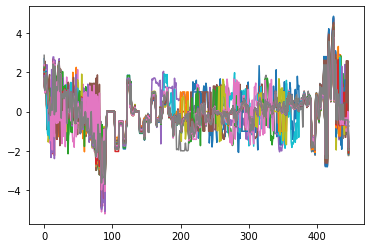

In [202]:
#show some concatenated time series for specific SDG and Continent
plt.plot(continents_prep_g['Europe'][1-1].T)
plt.show()

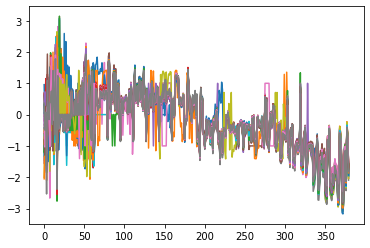

In [204]:
plt.plot(continents_prep_g['Europe'][2-1].T)
plt.show()

## d-HSIC between goals

We compute the d-HSIC on a goal level and perform and independence test.

### Combinations

We need to compute this statistic on all possible d-combinations of the 17 SDGs. Therefore, we create the following functions that given a set and a number r computes all possible combinations without order.

In [17]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [18]:
def combinations_tuple(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

## d-HSIC implementation

In [3]:
def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

In [4]:
def make_K_list(X_list, n_samples, n_nodes):
    """
    Computes the kernel matrices of the variables in X_array, where each column represents one variable.
    Returns a list of the kernel matrices of each variable.
    """
    k_list = list(pairwise_kernels(X_list[i], metric='rbf', gamma=0.5/(width(X_list[i])**2)) for i in range(n_nodes))
    return k_list

In [5]:
def dHSIC(k_list):
    """
    Computes the dHSIC statistic
    """
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    term1, term2, term3 = 1, 1, 2/n_samples    
    for j in range(n_nodes):
        term1 = term1 * k_list[j]
        term2 = term2 * np.sum(k_list[j]) / (n_samples**2)
        term3 = term3 * np.sum(k_list[j], axis=0) / n_samples
    term1_sum = np.sum(term1)
    term3_sum = np.sum(term3)
    dHSIC = term1_sum/(n_samples**2) + term2 - term3_sum
    return dHSIC

In [6]:
def dHSIC_permutation(k_list, n_samples, n_nodes, n_perms=5000, alpha=0.05):
    """
    Approximates the null distribution by permutating all variables
    """
    # initiating statistics
    statistics = np.zeros(n_perms)
    
    for i in range(n_perms):
        term1 = k_list[0]
        term2 = np.sum(k_list[0])/(n_samples**2)
        term3 = 2 * np.sum(k_list[0], axis=0) / (n_samples**2)

        for j in range(1, n_nodes):
            index_perm = np.random.permutation(k_list[j].shape[0])
            k_perm = k_list[j][index_perm, index_perm[:, None]]

            term1 = term1 * k_perm
            term2 = term2 * np.sum(k_perm) / (n_samples**2)
            term3 = term3 * np.sum(k_perm, axis=0) / n_samples

        term1_sum = np.sum(term1)
        term3_sum = np.sum(term3)

        statistics[i] = term1_sum/(n_samples**2) + term2 - term3_sum
    
    statistics_sort = np.sort(statistics)
    # computing 1-alpha threshold
    threshold = statistics_sort[round((1-alpha)*n_perms)]
    return threshold

In [8]:
def joint_independence_test2(X_list, n_perms=5000, alpha=0.05):
    """
    Performs the independence test with HSIC and returns an accept or reject statement
    
    Inputs:
    X_list: list of variables, each having dimensions (n_samples, n_obs)  
    n_perms: number of permutations performed when bootstrapping the null
    alpha: rejection threshold of the test
    make_K: function called to construct the kernel matrix 
    
    Returns:
    reject: 1 if null rejected, 0 if null accepted
    
    """
    
    n_nodes = len(X_list)
    n_samples, n_obs = X_list[0].shape
    
    # compute list of kernel matrices
    K_list = make_K_list(X_list, n_samples, n_nodes)
    
    # statistic and threshold
    stat = dHSIC(K_list)
    threshold = dHSIC_permutation(K_list, n_samples, n_nodes)
    reject = int(stat > threshold)
    
    return reject

In [152]:
def dHSIC_links(group, groups_data, iterable):
    edges = {}
    Adj2 = np.zeros((17,17))
    r = 2
    e = 0
    g_combinations = list(combinations_tuple(iterable, r))
    group_arr = groups_data[group]
    while len(g_combinations) >0 :
        f = 0
        print("combinations: ", r)
        print("number of combinations available: ", len(g_combinations))
        hsic_found = {}
        for comb in g_combinations: 
            X_list = []
            for i in range(r):
                X_list.append(group_arr[int(comb[i])-1])
            reject = joint_independence_test2(X_list)
            hsic_found[comb] = reject
            if reject == 1:
                e += 1
                f += 1
                edges[e] = tuple(comb)
                if r == 2:
                    Adj2[int(comb[0])-1, int(comb[1])-1] = reject
                    Adj2[int(comb[1])-1, int(comb[0])-1] = reject
        print("Edges found with " ,r, "nodes: ", f)
        r +=1
        if r==18:
            break
        g_combinations_all = list(combinations_tuple(iterable, r))
        g_combinations = copy.deepcopy(g_combinations_all)

        for comb_n in g_combinations_all:
            gg = list(combinations_tuple(comb_n, r-1))
            for l in range(len(gg)):
                if (gg[l] in hsic_found and hsic_found[gg[l]]==1) or (gg[l] not in hsic_found):
                    g_combinations.remove(comb_n)
                    break
                   
    return edges, Adj2

In [153]:
edges_e, Adj2_e = dHSIC_links('Europe', continents_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  79
combinations:  3
number of combinations available:  92
Edges found with  3 nodes:  11
combinations:  4
number of combinations available:  61
Edges found with  4 nodes:  1
combinations:  5
number of combinations available:  22
Edges found with  5 nodes:  1
combinations:  6
number of combinations available:  3
Edges found with  6 nodes:  0


In [161]:
edges_af, Adj2_af = dHSIC_links('Africa', continents_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  50
combinations:  3
number of combinations available:  181
Edges found with  3 nodes:  18
combinations:  4
number of combinations available:  119
Edges found with  4 nodes:  1
combinations:  5
number of combinations available:  28
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  1
Edges found with  6 nodes:  0


In [162]:
edges_as, Adj2_as = dHSIC_links('Asia', continents_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  80
combinations:  3
number of combinations available:  77
Edges found with  3 nodes:  9
combinations:  4
number of combinations available:  33
Edges found with  4 nodes:  2
combinations:  5
number of combinations available:  3
Edges found with  5 nodes:  0


In [164]:
edges_am, Adj2_am = dHSIC_links('Americas', continents_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  42
combinations:  3
number of combinations available:  241
Edges found with  3 nodes:  25
combinations:  4
number of combinations available:  230
Edges found with  4 nodes:  14
combinations:  5
number of combinations available:  89
Edges found with  5 nodes:  7
combinations:  6
number of combinations available:  7
Edges found with  6 nodes:  0


In [165]:
# better save these precious data
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Europe.pkl', 'wb')
pickle.dump(edges_e, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Asia.pkl', 'wb')
pickle.dump(edges_as, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Africa.pkl', 'wb')
pickle.dump(edges_af, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Americas.pkl', 'wb')
pickle.dump(edges_am, hs)
hs.close()

In [ ]:
# CHECKPOINT
edges_e = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Europe.pkl', 'rb'))
edges_as = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Asia.pkl', 'rb'))
edges_af = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Africa.pkl', 'rb'))
edges_am = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Americas.pkl', 'rb'))

## Visualisation

In [138]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [31]:
!pip install hypernetx

%load_ext autoreload
%autoreload 2
import hypernetx as hnx

  Using cached hypernetx-0.3.7-py3-none-any.whl (46 kB)
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [154]:
n_labels = {}
for i in range(17):
    n_labels[i] = i+1

### Europe

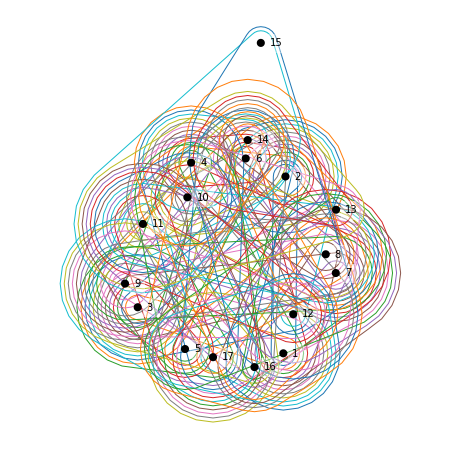

In [155]:
#hypergraph
He = hnx.Hypergraph(edges_e)
hnx.draw(He, with_edge_labels=False)

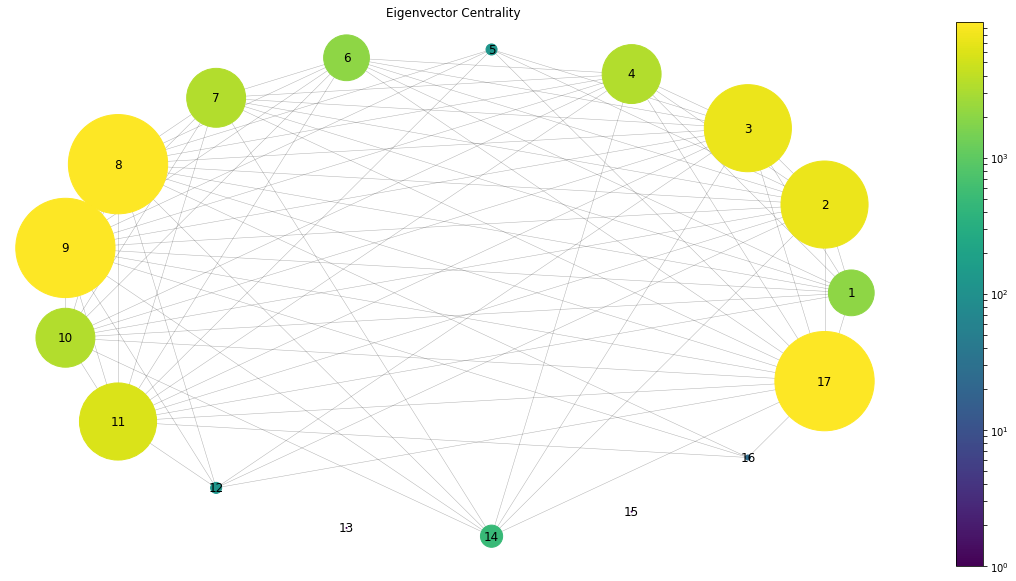

In [160]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_e)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(np.exp(30*i) for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(np.exp(30*i) for i in degree.values()), nodelist=list(degree.keys()))
nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Asia

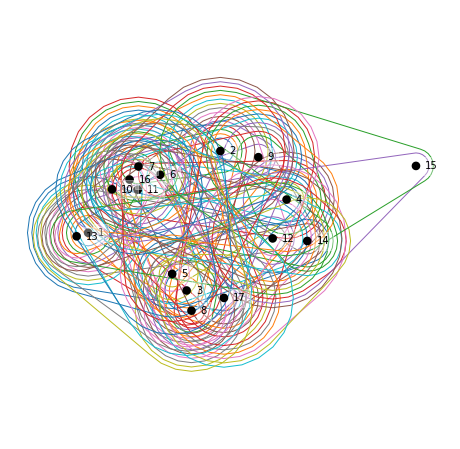

In [166]:
#hypergtraph
Has = hnx.Hypergraph(edges_as)
hnx.draw(Has, with_edge_labels=False)

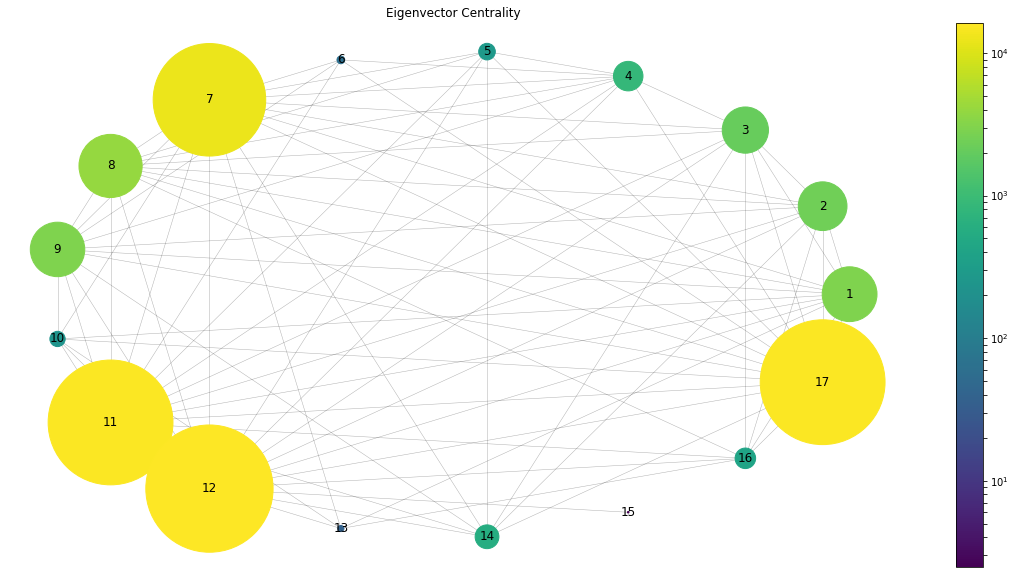

In [167]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_as)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(np.exp(30*i) for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(np.exp(30*i) for i in degree.values()), nodelist=list(degree.keys()))
nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Africa

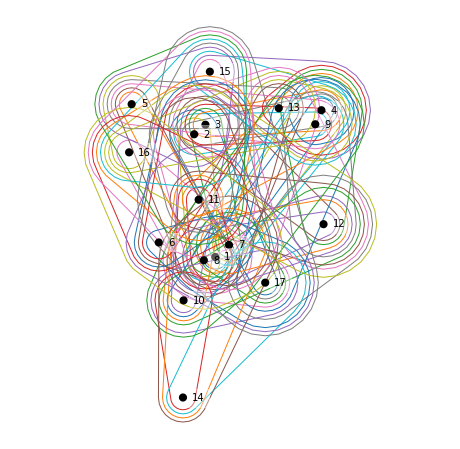

In [168]:
#hypergraph
Haf = hnx.Hypergraph(edges_af)
hnx.draw(Haf, with_edge_labels=False)

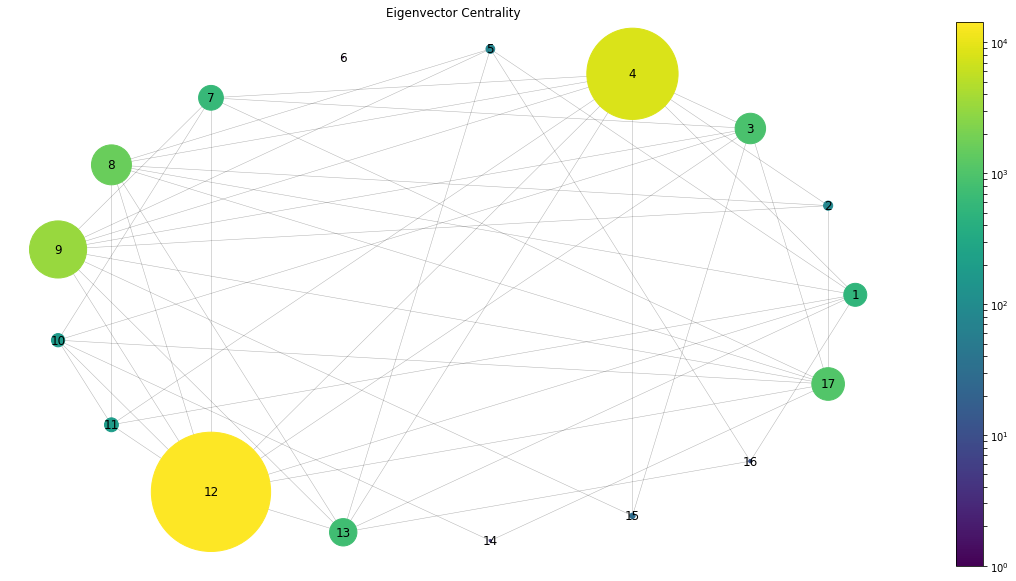

In [171]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_af)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(np.exp(25*i) for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(np.exp(25*i) for i in degree.values()), nodelist=list(degree.keys()))
nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Americas

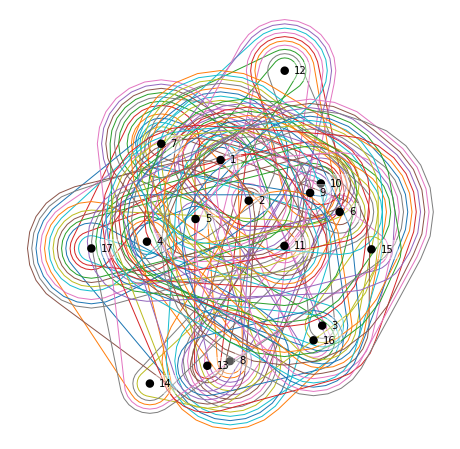

In [172]:
#hypergraph
Ham = hnx.Hypergraph(edges_am)
hnx.draw(Ham, with_edge_labels=False)

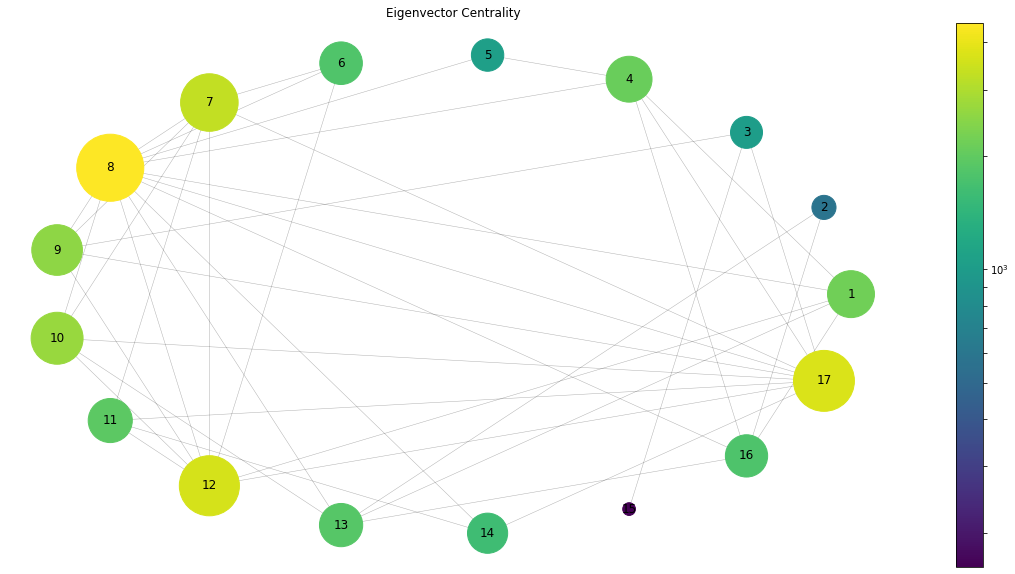

In [180]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_am)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(10000*i for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(10000*i for i in degree.values()), nodelist=list(degree.keys()))
nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

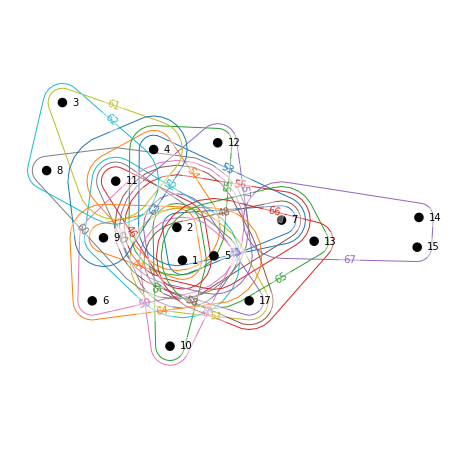

In [182]:
Ham_restrict_edges3 = Ham.restrict_to_edges(list(range(43,68)))
hnx.draw(Ham_restrict_edges3)

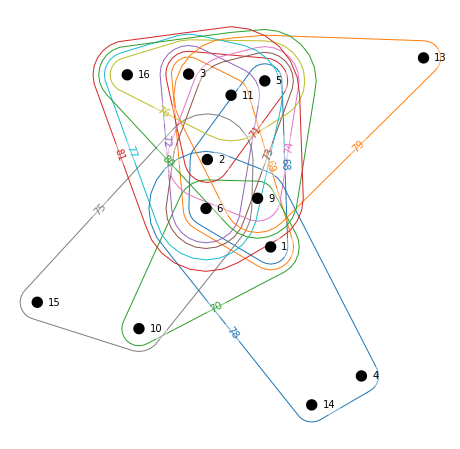

In [185]:
Ham_restrict_edges4 = Ham.restrict_to_edges(list(range(68,82)))
hnx.draw(Ham_restrict_edges4)

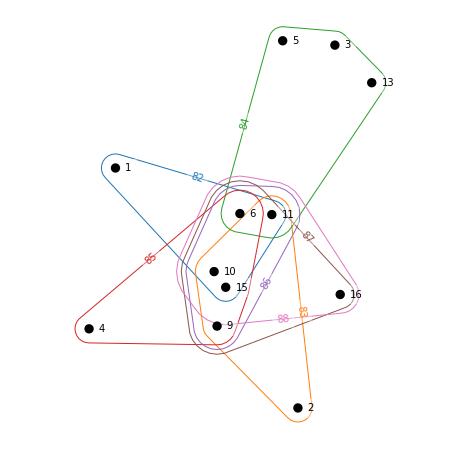

In [191]:
Ham_restrict_edges5 = Ham.restrict_to_edges(list(range(82,89)))
hnx.draw(Ham_restrict_edges5)

## Trying different visualisations of hypergraphs

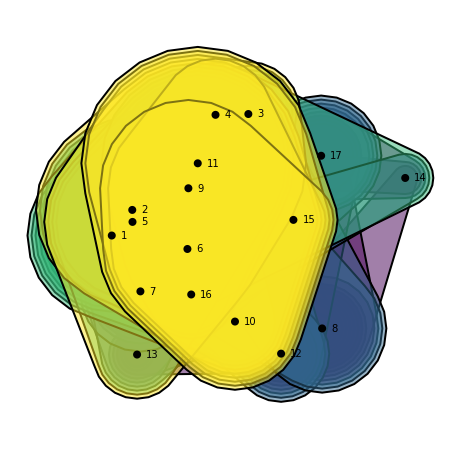

In [192]:
#Trying out different visualizations
cmap = plt.cm.viridis
alpha = .5

sizes = np.array([len(e) for e in H.edges()])
norm = plt.Normalize(sizes.min(), sizes.max())

hnx.drawing.draw(Ham,
                 label_alpha=0,
                 edges_kwargs={
                     'facecolors': cmap(norm(sizes))*(1, 1, 1, alpha),
                     'edgecolors': 'black',
                     'linewidths': 2
                 }, with_edge_labels=False)

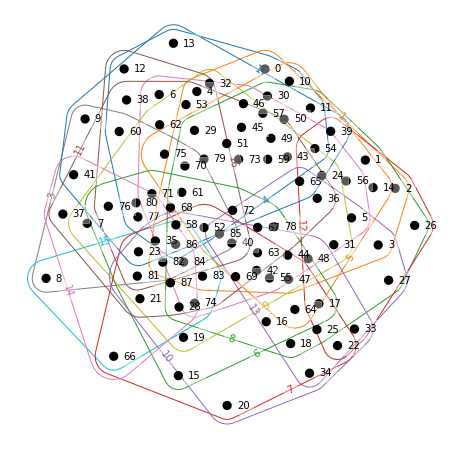

In [193]:
HD = H.dual()
hnx.draw(HD)

In [194]:
Ham.degree('17')

13

In [195]:
# As with any iterator you can get all of the values in a list
list(Ham.neighbors('6'))

['16',
 '9',
 '10',
 '11',
 '2',
 '1',
 '7',
 '3',
 '14',
 '12',
 '13',
 '8',
 '5',
 '15',
 '4']

In [196]:
Ham.incidence_dict

{1: {'1', '4'},
 2: {'1', '8'},
 3: {'1', '12'},
 4: {'1', '13'},
 5: {'1', '16'},
 6: {'13', '2'},
 7: {'16', '2'},
 8: {'3', '9'},
 9: {'15', '3'},
 10: {'17', '3'},
 11: {'4', '5'},
 12: {'4', '8'},
 13: {'16', '4'},
 14: {'17', '4'},
 15: {'5', '8'},
 16: {'6', '7'},
 17: {'6', '8'},
 18: {'12', '6'},
 19: {'7', '8'},
 20: {'7', '9'},
 21: {'10', '7'},
 22: {'11', '7'},
 23: {'12', '7'},
 24: {'17', '7'},
 25: {'8', '9'},
 26: {'10', '8'},
 27: {'12', '8'},
 28: {'13', '8'},
 29: {'14', '8'},
 30: {'16', '8'},
 31: {'17', '8'},
 32: {'12', '9'},
 33: {'17', '9'},
 34: {'10', '12'},
 35: {'10', '13'},
 36: {'10', '17'},
 37: {'11', '12'},
 38: {'11', '14'},
 39: {'11', '17'},
 40: {'12', '17'},
 41: {'13', '16'},
 42: {'14', '17'},
 43: {'1', '2', '7'},
 44: {'1', '2', '9'},
 45: {'1', '10', '2'},
 46: {'1', '11', '2'},
 47: {'1', '17', '2'},
 48: {'1', '5', '7'},
 49: {'1', '10', '5'},
 50: {'1', '11', '5'},
 51: {'1', '17', '5'},
 52: {'1', '11', '9'},
 53: {'2', '4', '7'},
 54: {